# Read in the Raw Data, Load the YAML metadata, and Clean the Data

In [1]:
# Import the required modules

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import numpy as np
import scipy as sp

import yaml
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin


In [2]:
# Read in the raw CSV data, and then print the count of observations and variables
# https://www.fhfa.gov/sites/default/files/2024-06/nsmo_v50_1321_puf.csv

raw_df = pd.read_csv('nsmo_v50_1321_puf.csv')
raw_df.shape

(50542, 543)

In [3]:
# Load YAML files containing metadata into Python as dictionaries

# Load the labels of each variable into a dictionary
# https://www.fhfa.gov/sites/default/files/2024-06/nsmo_v50_labels.sas

with open('variable_labels.yaml', 'r') as file:
    variable_labels_dict = yaml.safe_load(file)
    
# Load the the format of each variable into a dictionary
# https://www.fhfa.gov/sites/default/files/2024-06/nsmo_v50_labels.sas

with open('variable_formats.yaml', 'r') as file:
    variable_formats_dict = yaml.safe_load(file)
    
# Load the categories for every categorical variable (exclude null categories) into a dictionary
# https://www.fhfa.gov/sites/default/files/2024-06/nsmo_v50_formats.sas

with open('categorical_variables_categories.yaml', 'r') as file:
    categorical_variables_categories_dict = yaml.safe_load(file)

In [4]:
# Clean data by converting negative values and "." values (representing missing values) into null values (i.e., NaN)

for col in raw_df.columns:
    # Exclude the Mortgage Performance Status variables because they have letters representing specific categories
    if variable_formats_dict[col] != 'PSTATFM':
        raw_df.loc[raw_df[col] < 0, col] = np.nan
        raw_df.loc[raw_df[col] == ".", col] = np.nan

In [5]:
# Check out a few obs after data cleaning

raw_df.tail()

,nsmoid,survey_wave,analysis_weight,x05a,x05b,x05c,x05d,x05e,x05f,x05g,...,mtmltv0621,mtmltv0921,mtmltv1221,mtmltv0322,mtmltv0622,mtmltv0922,mtmltv1222,mtmltv0323,mtmltv0623,mtmltv0923
50537,531289.000,34.000,2117.790,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,NaN,NaN,64.000,61.000,59.000,59.000,59.000,59.000,59.000,60.000
50538,546643.000,34.000,1738.920,3.000,3.000,2.000,2.000,2.000,1.000,3.000,...,NaN,NaN,79.000,77.000,74.000,72.000,72.000,71.000,71.000,71.000
50539,512993.000,34.000,2353.260,1.000,2.000,2.000,2.000,2.000,1.000,2.000,...,NaN,NaN,95.000,91.000,88.000,85.000,84.000,84.000,83.000,82.000
50540,518631.000,34.000,5283.750,3.000,3.000,3.000,3.000,3.000,3.000,3.000,...,NaN,NaN,56.000,53.000,50.000,49.000,49.000,49.000,48.000,48.000
50541,544740.000,34.000,1738.920,1.000,1.000,1.000,1.000,1.000,1.000,2.000,...,NaN,NaN,80.000,74.000,69.000,66.000,65.000,64.000,63.000,63.000


In [6]:
# Create a set of all variable formats

variable_formats_set = set(variable_formats_dict.values())

In [7]:
# Create a list of the categorical variables and a list of the numeric variables

categorical_variables = []
numeric_variables = []

categorical_variable_formats = set(categorical_variables_categories_dict.keys())
numeric_variable_formats = variable_formats_set - categorical_variable_formats

for col in raw_df.columns:
    if variable_formats_dict[col] in categorical_variable_formats:
        categorical_variables.append(col)
    elif variable_formats_dict[col] in numeric_variable_formats:
        numeric_variables.append(col)
    else:
        print("Error in bifurcation")

In [8]:
raw_df.tail()

,nsmoid,survey_wave,analysis_weight,x05a,x05b,x05c,x05d,x05e,x05f,x05g,...,mtmltv0621,mtmltv0921,mtmltv1221,mtmltv0322,mtmltv0622,mtmltv0922,mtmltv1222,mtmltv0323,mtmltv0623,mtmltv0923
50537,531289.000,34.000,2117.790,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,NaN,NaN,64.000,61.000,59.000,59.000,59.000,59.000,59.000,60.000
50538,546643.000,34.000,1738.920,3.000,3.000,2.000,2.000,2.000,1.000,3.000,...,NaN,NaN,79.000,77.000,74.000,72.000,72.000,71.000,71.000,71.000
50539,512993.000,34.000,2353.260,1.000,2.000,2.000,2.000,2.000,1.000,2.000,...,NaN,NaN,95.000,91.000,88.000,85.000,84.000,84.000,83.000,82.000
50540,518631.000,34.000,5283.750,3.000,3.000,3.000,3.000,3.000,3.000,3.000,...,NaN,NaN,56.000,53.000,50.000,49.000,49.000,49.000,48.000,48.000
50541,544740.000,34.000,1738.920,1.000,1.000,1.000,1.000,1.000,1.000,2.000,...,NaN,NaN,80.000,74.000,69.000,66.000,65.000,64.000,63.000,63.000


In [9]:
# Check out a few obs for just the categorical variable

raw_df[categorical_variables].tail()

,x05a,x05b,x05c,x05d,x05e,x05f,x05g,x06,x07,x08a,...,forb0621,forb0921,forb1221,forb0322,forb0622,forb0922,forb1222,forb0323,forb0623,forb0923
50537,1.000,1.000,1.000,1.000,1.000,1.000,1.000,3.000,2.000,1.000,...,NaN,NaN,NaN,NaN,2.000,2.000,2.000,2.000,2.000,2.000
50538,3.000,3.000,2.000,2.000,2.000,1.000,3.000,3.000,3.000,2.000,...,NaN,NaN,NaN,2.000,2.000,2.000,2.000,2.000,2.000,2.000
50539,1.000,2.000,2.000,2.000,2.000,1.000,2.000,3.000,2.000,1.000,...,NaN,NaN,NaN,NaN,2.000,2.000,2.000,2.000,2.000,2.000
50540,3.000,3.000,3.000,3.000,3.000,3.000,3.000,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,2.000,2.000,2.000,2.000,2.000,2.000
50541,1.000,1.000,1.000,1.000,1.000,1.000,2.000,3.000,2.000,1.000,...,NaN,NaN,NaN,2.000,2.000,2.000,2.000,2.000,2.000,2.000


In [10]:
# Check out a few obs for just the numeric variable

raw_df[numeric_variables].tail()

,nsmoid,survey_wave,analysis_weight,x74r,rate_spread,pmms,term,ltv,cltv,dti,...,mtmltv0621,mtmltv0921,mtmltv1221,mtmltv0322,mtmltv0622,mtmltv0922,mtmltv1222,mtmltv0323,mtmltv0623,mtmltv0923
50537,531289.000,34.000,2117.790,57.000,0.640,3.110,40.000,64.000,64.000,42.000,...,NaN,NaN,64.000,61.000,59.000,59.000,59.000,59.000,59.000,60.000
50538,546643.000,34.000,1738.920,37.000,0.030,3.100,30.000,79.000,79.000,33.000,...,NaN,NaN,79.000,77.000,74.000,72.000,72.000,71.000,71.000,71.000
50539,512993.000,34.000,2353.260,26.000,NaN,3.100,30.000,95.000,95.000,35.000,...,NaN,NaN,95.000,91.000,88.000,85.000,84.000,84.000,83.000,82.000
50540,518631.000,34.000,5283.750,36.000,NaN,3.100,20.000,56.000,56.000,46.000,...,NaN,NaN,56.000,53.000,50.000,49.000,49.000,49.000,48.000,48.000
50541,544740.000,34.000,1738.920,42.000,0.080,3.050,30.000,80.000,80.000,20.000,...,NaN,NaN,80.000,74.000,69.000,66.000,65.000,64.000,63.000,63.000


In [11]:
# View survey answers for any given observation in a human readable format using the YAML metadata
# Deactivated code below because it will print 500+ lines because we have 500+ variables

if False:
    one_obs = raw_df.iloc[50541]
    # Loop through all columns for one obs
    for col, value in one_obs.items():
        # if it's a categorical variable, then look up the category
        if not(pd.isna(value)) and col in categorical_variables:
            print(variable_labels_dict[col], ":", categorical_variables_categories_dict[variable_formats_dict[col]][value])
        # else it's a numeric variable or null
        else:
            print(variable_labels_dict[col], ":", value)

# Join with External Data: 30-year Treasury Yields (i.e., the Risk-Free Rate)

In [12]:
# Read in the raw CSV data for Market Yields on U.S. Treasury Securities at 30-Year Constant Maturity
# https://fred.stlouisfed.org/series/DGS30

treasury_yields_df = pd.read_csv('DGS30.csv')

In [13]:
# Create new columns based upon the observation date, which will be used in join to the main data

treasury_yields_df['observation_date'] = pd.to_datetime(treasury_yields_df['observation_date'])
treasury_yields_df['observation_year'] = treasury_yields_df['observation_date'].dt.year
treasury_yields_df['observation_month'] = treasury_yields_df['observation_date'].dt.month

In [14]:
# Check out the daily obsevations of DGS30, which represents the 30-year Treasury Yield (i.e., the Risk-Free Rate)

treasury_yields_df.tail()

,observation_date,DGS30,observation_year,observation_month
2343,2021-12-27,1.880,2021,12
2344,2021-12-28,1.900,2021,12
2345,2021-12-29,1.960,2021,12
2346,2021-12-30,1.930,2021,12
2347,2021-12-31,1.900,2021,12


In [15]:
# Calculate the average Treasury Yields over each Year and Month

average_treasury_yields_df = treasury_yields_df.groupby(['observation_year', 'observation_month'])['DGS30'].mean()
average_treasury_yields_df = average_treasury_yields_df.to_frame().reset_index()

In [16]:
# Check out the average Treasury Yields over each Year and Month

average_treasury_yields_df.head()

,observation_year,observation_month,DGS30
0,2013,1,3.080
1,2013,2,3.165
2,2013,3,3.163
3,2013,4,2.933
4,2013,5,3.113


In [17]:
# Left join the Treasury Yields to the raw Mortgage Origination data using the composite keys of year and month

merged_df = pd.merge(left=raw_df, 
                     right=average_treasury_yields_df,
                     left_on=['open_year', 'open_month'],
                     right_on=['observation_year', 'observation_month'],
                     how='left')

# Drop the redundant columns of composite keys used in join

merged_df = merged_df.drop(['observation_year', 'observation_month'], axis=1)

In [18]:
# Check out the data after the left join

merged_df.head()

,nsmoid,survey_wave,analysis_weight,x05a,x05b,x05c,x05d,x05e,x05f,x05g,...,mtmltv0921,mtmltv1221,mtmltv0322,mtmltv0622,mtmltv0922,mtmltv1222,mtmltv0323,mtmltv0623,mtmltv0923,DGS30
0,509550.000,1.000,1207.580,3.000,3.000,3.000,3.000,3.000,1.000,3.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.080
1,503017.000,1.000,1207.580,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.165
2,514904.000,1.000,1027.740,1.000,2.000,1.000,1.000,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.080
3,525176.000,1.000,1711.910,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.080
4,540654.000,1.000,918.850,1.000,1.000,2.000,1.000,2.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.080


In [19]:
# Derivation of Beta, which is a new variable

notes = """
Re = Rf + β(Rm − Rf)
Re - Rf = β(Rm − Rf)
(Re - Rf) = β(Rm − Rf)
(Re - Rf) / (Rm − Rf) = β
β = (Re - Rf) / (Rm − Rf)

'rate_spread' = Re - 'PMMS'
'rate_spread' + 'PMMS' = Re 
Re = 'rate_spread' + 'PMMS'

β = ('rate_spread' + 'PMMS' - Rf) / (Rm − Rf)
β = ('rate_spread' + 'PMMS' - 'treasury_yield') / ('PMMS' − 'treasury_yield')
"""

In [20]:
# Calculation: Beta = ('rate_spread' + 'pmms' - 'treasury_yield') / ('pmms' − 'treasury_yield')

merged_df['Beta'] = (merged_df['rate_spread'] + merged_df['pmms'] - merged_df['DGS30']) / (merged_df['pmms'] - merged_df['DGS30'])

In [21]:
# Describe the distribution of Beta

merged_df['Beta'].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count        34163.000
mean       -217191.309
std        8483767.330
min     -656705858.722
1%             -12.000
5%              -0.389
10%              1.000
25%              1.100
50%              1.276
75%              1.623
90%              2.294
95%              3.270
99%              8.731
max           1047.500
Name: Beta, dtype: float64

In [22]:
# Winsorize the Beta values to reduce the influence of outliers
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html

merged_df['Beta_winsorized'] = sp.stats.mstats.winsorize(merged_df['Beta'], limits=[0.05,0.05])

In [23]:
# Append the new numeric variables to the list of all numeric variables

numeric_variables.append('DGS30')
numeric_variables.append('Beta')
numeric_variables.append('Beta_winsorized')

# Process the Data using Dummy Coding, Partitioning, Imputing, and then Scaling

In [24]:
# Create dummy variables for each category for each categorical variable

processed_df = pd.get_dummies(merged_df, columns=categorical_variables)

In [25]:
# Remove the ".0" in many of the dummy variable due to the columns in the raw data being floats

new_columns_list = []
for col in processed_df.columns:
    new_col = col.replace(".0", "")
    new_columns_list.append(new_col)
    
processed_df.columns = new_columns_list

In [26]:
# Retrieve the names of the new categorical variables (i.e., the dummy variables)

new_categorical_variables = []
for col in processed_df.columns:
    if col not in numeric_variables:
        new_categorical_variables.append(col)

In [27]:
# Check out a few obs for just the new categorical variable

processed_df[new_categorical_variables].tail()

,x05a_1,x05a_2,x05a_3,x05b_1,x05b_2,x05b_3,x05c_1,x05c_2,x05c_3,x05d_1,...,forb0922_1,forb0922_2,forb1222_1,forb1222_2,forb0323_1,forb0323_2,forb0623_1,forb0623_2,forb0923_1,forb0923_2
50537,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,0,1,0,1,0,1
50538,0,0,1,0,0,1,0,1,0,0,...,0,1,0,1,0,1,0,1,0,1
50539,1,0,0,0,1,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,1
50540,0,0,1,0,0,1,0,0,1,0,...,0,1,0,1,0,1,0,1,0,1
50541,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,0,1,0,1,0,1


In [28]:
# Identify the target variable

target_variable = 'Beta_winsorized'

In [29]:
# List variables to be excluded

exclude_variables = ['nsmoid',          # NSMO Identification Number
                     'survey_wave',     # NSMO Survey Wave (Quarterly)
                     'analysis_weight', # NSMO Analysis Weight (Sampling Weight x Non-response Adjustment)
                     'rate_spread',     # Mortgage Interest Rate Spread at Origination (Percent)
                     'pmms',            # Freddie Mac's Primary Mortgage Market Survey (PMMS) Rate at Origination (Percent)
                     'DGS30',           # Market Yield on U.S. Treasury Securities at 30-Year Constant Maturity, Quoted on an Investment Basis
                     'Beta'             # Original Beta before it was winsorized
                    ]

In [30]:
# Create a compete list of all excluded variables and exclude them from the list of numeric variables

list_of_excluded_variables = list([target_variable]) + exclude_variables

for excluded_variable in list_of_excluded_variables:
    numeric_variables.remove(excluded_variable)

print(list_of_excluded_variables)

['Beta_winsorized', 'nsmoid', 'survey_wave', 'analysis_weight', 'rate_spread', 'pmms', 'DGS30', 'Beta']


In [31]:
# Calculate the percentage of missing values in the target variable

sum_of_missing_values_in_target = processed_df[target_variable].isna().sum()
print("sum of missing values in target: ", sum_of_missing_values_in_target, 
      "\ntotal observations in data: ", processed_df.shape[0], 
      "\npercentage of target with missing values: ", round(sum_of_missing_values_in_target / processed_df.shape[0] * 100,1), "%")

sum of missing values in target:  16379 
total observations in data:  50542 
percentage of target with missing values:  32.4 %


In [32]:
# Drop observations in the data where the target variable has missing values

processed_df = processed_df.dropna(subset=target_variable)

In [33]:
# Segregate the predictor variables from the target variable

X = processed_df.drop(columns=list_of_excluded_variables)
y = processed_df[target_variable]

In [34]:
# Split the data into training and testing partitions

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=0)

In [35]:
# Impute missing values for the numeric variables using the mean values

# Instantiate an imputer object
imputer = SimpleImputer(strategy='mean')

# Prevent "data leakage" by fitting the imputer on just the training data, and then apply it to the holdout testing data
imputer.fit(X_train[numeric_variables])

# Transform both the training and testing data using the imputer fitted on just the training data
X_train[numeric_variables] = imputer.transform(X_train[numeric_variables])
X_test[numeric_variables] = imputer.transform(X_test[numeric_variables])

In [36]:
# Scale values for the numeric variables

# Instantiate a scaler object
scaler = StandardScaler()

# Prevent "data leakage" by fitting the scaler on just the imputed training data, and then apply it to the holdout testing data
scaler.fit(X_train[numeric_variables])

# Scale both the training data and testing data using the scaler fitted on just the training data
X_train[numeric_variables] = scaler.transform(X_train[numeric_variables])
X_test[numeric_variables] = scaler.transform(X_test[numeric_variables])

# Supervised Learning Models: Gradient Boosting, Linear, LASSO, and Random Forest

In [37]:
# Fit a Gradient Boosting Regression model on the training partition, and then evaluate it on the testing partition
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html

params = {'max_depth': 4, 'learning_rate': 0.01, 'random_state':0}
grad_boost_reg = HistGradientBoostingRegressor(**params)
grad_boost_reg.fit(X_train, y_train)

mae = mean_absolute_error(y_test, grad_boost_reg.predict(X_test))
mse = mean_squared_error(y_test, grad_boost_reg.predict(X_test))
rmse = np.sqrt(mse)
grad_boost_reg_dict = {"model": "Gradient Boosting Regression", 
                       "Mean Absolute Error": mae, 
                       "Root Mean Squared Error": rmse}

In [38]:
# Fit a Linear Model on the training partition, and evaluate it on the testing partition
# There is a lot of Multicollinearity in this model because we are putting all predictor variables into the model
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train,y_train)

mae = mean_absolute_error(y_test, linear_reg.predict(X_test))
mse = mean_squared_error(y_test, linear_reg.predict(X_test))
rmse = np.sqrt(mse)
linear_reg_dict = {"model": "Linear Regression", 
                   "Mean Absolute Error": mae, 
                   "Root Mean Squared Error": rmse}

In [39]:
# Fit a LASSO regression on the training partition, and then evaluate it on the testing partition
# This will shrink most of the variable coefficients to zero for automated variable selection
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso
# Default hyperparameters: alpha=1.0, max_iter=1000, tol=0.0001

linear_reg_with_lasso = linear_model.Lasso(alpha=1.0, max_iter=1000, tol=0.0001)
linear_reg_with_lasso.fit(X_train,y_train)

mae = mean_absolute_error(y_test, linear_reg_with_lasso.predict(X_test))
mse = mean_squared_error(y_test, linear_reg_with_lasso.predict(X_test))
rmse = np.sqrt(mse)
lasso_reg_dict = {"model": "LASSO Regression", 
                   "Mean Absolute Error": mae, 
                   "Root Mean Squared Error": rmse}

In [40]:
# Use the LASSO regression to identify the most useful variable to predict the target (i.e., the variables whose coefficient didn't shrink to zero)

variable_names = list(X.columns) 
linear_reg_with_lasso_coef = linear_reg_with_lasso.coef_

for variable, coef in zip(variable_names, linear_reg_with_lasso_coef):
    # if the coefficient didn't shrink to zero
    if (coef != 0):
        # if it's a categorical variable
        if variable in new_categorical_variables:
            variable_substrings = variable.split("_")  # split up the new categorical variable name by underscores
            categorical_variable = '_'.join(variable_substrings[:-1])  # retrieve the original categorical variable name (e.g., 'x05a', 'perf_status_0923', etc.)
            category = variable_substrings[-1:][0]  # retrieve the category chosen for the categorical variable (e.g., '1', '10', '2013', 'A', etc.)
            if any(character.isdigit() for character in category):
                category = int(category)
            else:
                category = str(category)
            print(variable, ":", variable_labels_dict[categorical_variable], ":", categorical_variables_categories_dict[variable_formats_dict[categorical_variable]][category], ":", coef)
        # else it's a numeric variable
        else:
            print(variable, ":", variable_labels_dict[variable], ":", coef)

term : Mortgage Term (in Years) at Origination : -0.030274493016503857


In [41]:
# Fit a Random Forest regression model on the training partition, and then evaluate it on the testing partition
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

params = {'n_estimators': 100, 'max_depth': 4, 'random_state':0}
random_forest_reg = RandomForestRegressor(**params)
random_forest_reg.fit(X_train, y_train)

mae = mean_absolute_error(y_test, random_forest_reg.predict(X_test))
mse = mean_squared_error(y_test, random_forest_reg.predict(X_test))
rmse = np.sqrt(mse)
random_forest_reg_dict = {"model": "Random Forest Regression", 
                          "Mean Absolute Error": mae, 
                          "Root Mean Squared Error": rmse}

In [42]:
# Use the Random Forest regression model to identify the top N most important feature based upon their respective feature importance values

top_N = 20
feature_importances = pd.Series(data=random_forest_reg.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False, inplace=True)
top_N_features = feature_importances.head(top_N)

# Print the top N feature by importance from Random Forest regression model in descending order
for variable in top_N_features.index:
    feature_importance = top_N_features[variable]
    # if the feature importance is greater than zero
    if (feature_importance > 0):
        # if it's a categorical variable
        if variable in new_categorical_variables:
            variable_substrings = variable.split("_")  # split up the new categorical variable name by underscores
            categorical_variable = '_'.join(variable_substrings[:-1])  # retrieve the original categorical variable name (e.g., 'x05a', 'perf_status_0923', etc.)
            category = variable_substrings[-1:][0]  # retrieve the category chosen for the categorical variable (e.g., '1', '10', '2013', 'A', etc.)
            if any(character.isdigit() for character in category):
                category = int(category)
            else:
                category = str(category)
            print(variable, ":", variable_labels_dict[categorical_variable], ":", categorical_variables_categories_dict[variable_formats_dict[categorical_variable]][category], ":", feature_importance)
        # else it's a numeric variable
        else:
            print(variable, ":", variable_labels_dict[variable], ":", feature_importance)

term : Mortgage Term (in Years) at Origination : 0.10235085876214009
open_month_3 : Mortgage Origination Month : March : 0.09252733154141814
score_0620_r : VantageScore 3.0 in June 2020 | Respondent : 0.08593654496912963
perf_status_0321_Q : Mortgage Performance Status in March 2021 : Loan opened during this quarter : 0.05175874133425544
score_0920_r : VantageScore 3.0 in September 2020 | Respondent : 0.03824466824096512
x20b_2 : In the process of getting this mortgage from your mortgage lender/broker, did you... | Resolve credit reporterrors or problems : No : 0.031145347315436885
forb0621_1 : Flag Indicating Forbearance Status, June 2021 : In forbearance : 0.028682316596144543
x30b_1 : Was your home-buying course or counseling... | In person, in a group : Yes : 0.0255352922792512
score_0321_r : VantageScore 3.0 in March 2021 | Respondent : 0.019084388609276578
x79sa_7 : Current work status 1 | Spouse/Partner (work status selected by respondent involving the most employment) : Not wor

In [43]:
# Compare the performance metrics for the various models on the holdout testing data

all_model_performance_metrics = [grad_boost_reg_dict,
                                linear_reg_dict,
                                lasso_reg_dict,
                                random_forest_reg_dict]

all_model_performance_metrics_df = pd.DataFrame(all_model_performance_metrics)
print(all_model_performance_metrics_df)

                          model  Mean Absolute Error  Root Mean Squared Error
0  Gradient Boosting Regression                1.264                   11.567
1             Linear Regression                3.295                   12.571
2              LASSO Regression                1.406                   12.520
3      Random Forest Regression                1.357                   11.381


# Unsupervised Learning: K-means Clustering

In [44]:
# Concatenate X_train and X_test as X for Unsupervised Learning

X = pd.concat([X_train, X_test], axis=0)

In [45]:
# Compute K-means Clustering from K = 1 to 10 using Mini Batches to speed up computations
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html

list_of_inertia_for_each_K = []

for k in range(1, 11):
    mbk = MiniBatchKMeans(init ='k-means++', 
                          n_clusters = k,
                          batch_size = 100, 
                          n_init = 10,
                          max_no_improvement = 10, 
                          verbose = 0)

    mbk.fit(X)
    list_of_inertia_for_each_K.append(mbk.inertia_)

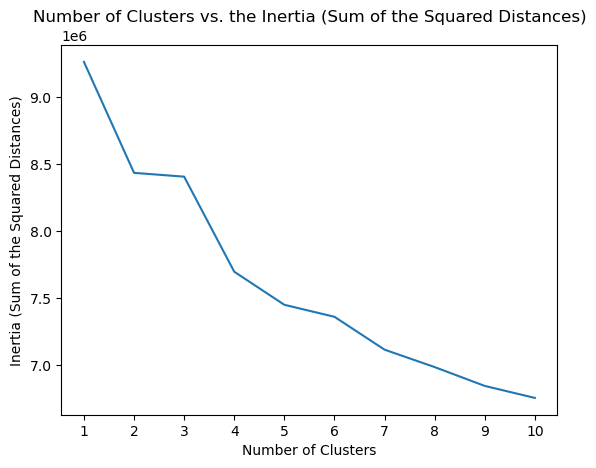

In [46]:
# Plot of the Number of Clusters vs. the Inertia of Mini Batch K-means Clustering

plt.plot(range(1, 11), list_of_inertia_for_each_K)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Sum of the Squared Distances)")
plt.title("Number of Clusters vs. the Inertia (Sum of the Squared Distances)")
plt.show()

In [47]:
# K-means Clustering with K=4 seems optimal because of the "elbow" point
# https://www.geeksforgeeks.org/ml-mini-batch-k-means-clustering-algorithm/

mbk = MiniBatchKMeans(init ='k-means++', 
                      n_clusters = 4,
                      batch_size = 100, 
                      n_init = 10,
                      max_no_improvement = 10, 
                      verbose = 0)

mbk.fit(X)
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis = 0)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

# Print out the cluster labels for each observation

print(mbk_means_labels)

[0 3 2 ... 3 2 2]
